In [1]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations
import h5py

import sys
sys.path.append("../src")
from inference import *
from analysis import *

In [2]:
import re

def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)


In [3]:
datapath = "../experiment_outputs/growth1_env_noise0.1"
log = h5py.File(f"{datapath}/data_generation_log.h5", "r")

print(f"n_species = {log.attrs['n_species']}")
print(f"avg_samp_dt = {log.attrs['avg_samp_dt']}")
print(f"env_noise = {log.attrs['env_noise']}")
print(f"meas_noise_list = {log.attrs['meas_noise_list']}")
print(f"n_params_seeds = {log.attrs['n_params_seeds']}")


n_species = [ 2  3  5 10]
avg_samp_dt = [3.  1.5 1. ]
env_noise = 0.1
meas_noise_list = [0.1]
n_params_seeds = 5


In [4]:
n_sp = 5
avg_samp_dt = 3.
env_noise = log.attrs["env_noise"]
meas_noise = 0.1
n_params_seeds = log.attrs['n_params_seeds']
params_seeds = [i.split("param_seed")[1]
                for i in os.listdir(f"{datapath}/{n_sp}_sp")]


In [5]:
def get_files(datapath, n_sp, env_noise, meas_noise, avg_samp_dt, filetype="dataset", ext="csv"):
    params_seeds = [i.split("param_seed")[1]
                    for i in os.listdir(f"{datapath}/{n_sp}_sp")]

    datafiles = []

    for p in params_seeds:
        datafiles.append(
            f"{datapath}/{n_sp}_sp/param_seed{p}/meas_noise{meas_noise}/t_samp{avg_samp_dt}/{filetype}{n_sp}_sp{p}_env_noise{env_noise}.{ext}")

    return datafiles


In [6]:
datafiles = [get_files(datapath, n_sp, env_noise, meas_noise, i)
             for i in log.attrs["avg_samp_dt"]]

inferfiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                        i, "inference") for i in log.attrs["avg_samp_dt"]]

metadatafiles = [get_files(datapath, n_sp, env_noise, meas_noise,
                           i, "metadata", "txt") for i in log.attrs["avg_samp_dt"]]


In [7]:
print(f"Numbers of sampling points: {log.attrs['n_samples']}")
print(f"Average sampling intervals: {log.attrs['avg_samp_dt'].round(3)}")
print(f"Number of initial conditions: {log.attrs['n_init_cond']}")
print(f"Number of repetitions: {log.attrs['repetitions']}")
print(f"Environmental noise: {log.attrs['env_noise']}")
print(f"Amounts of measurement noise: {log.attrs['meas_noise_list']}")


Numbers of sampling points: [11 21 31]
Average sampling intervals: [3.  1.5 1. ]
Number of initial conditions: 20
Number of repetitions: 1
Environmental noise: 0.1
Amounts of measurement noise: [0.1]


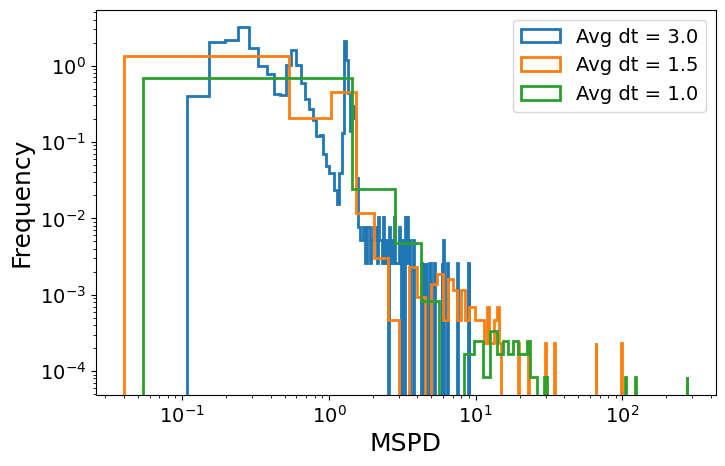

In [8]:
# MSPD frequency
plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.MSPD.values, 200,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()


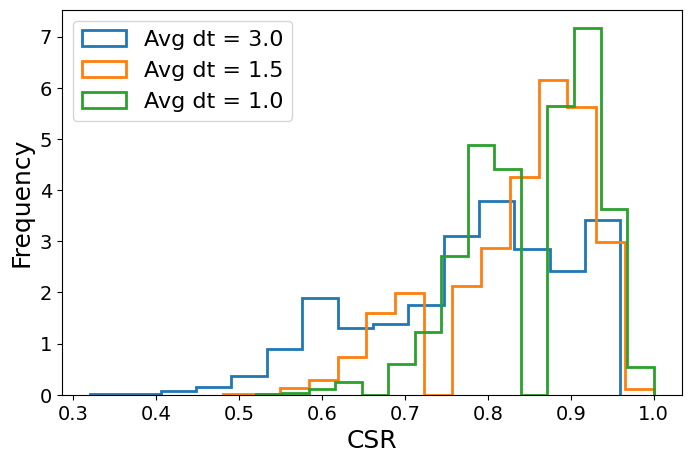

In [9]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.CSR.values, 15,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


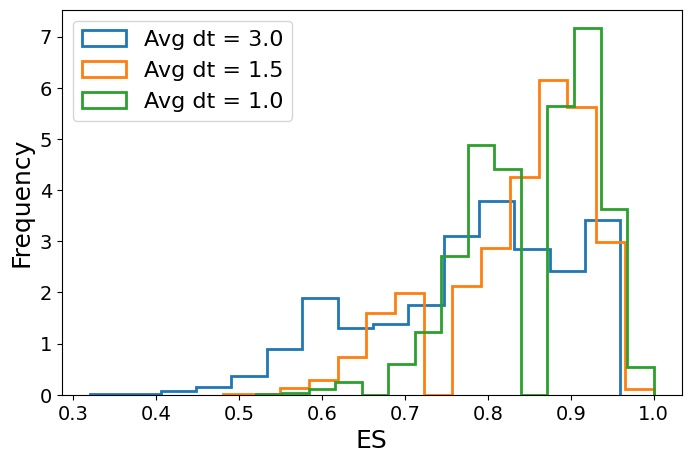

In [10]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)
    plt.hist(df.ES.values, 15,
             histtype="step", label=f"Avg dt = {log.attrs['avg_samp_dt'][i]}",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [11]:
# Difference between CSR and ES scores
# Difference between CSR and ES scores
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in inferfiles[0]], axis=0).reset_index(drop=True)
print((df.CSR != df.ES).sum())
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in inferfiles[1]], axis=0).reset_index(drop=True)
print((df.CSR != df.ES).sum())


0
0


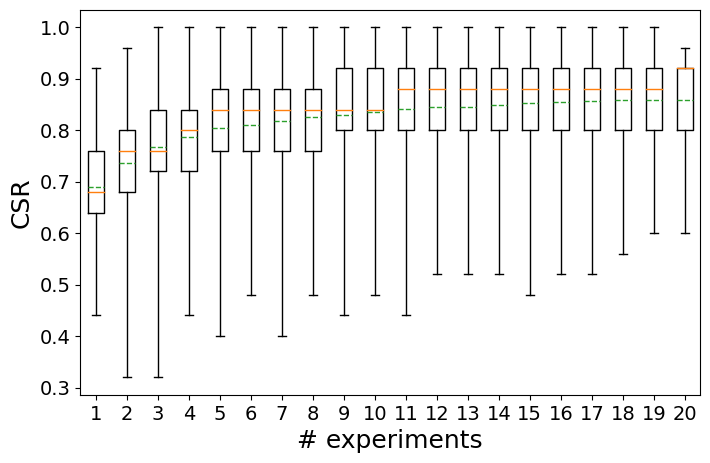

In [12]:
# CSR boxplots over # of experiments
df = pd.concat([pd.read_csv(i, index_col=0)
               for i in np.concatenate(inferfiles)], axis=0).reset_index(drop=True)
CSR = [df[df.n_init_cond == i]["CSR"].values for i in df.n_init_cond.unique()]

plt.figure(figsize=(8, 5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


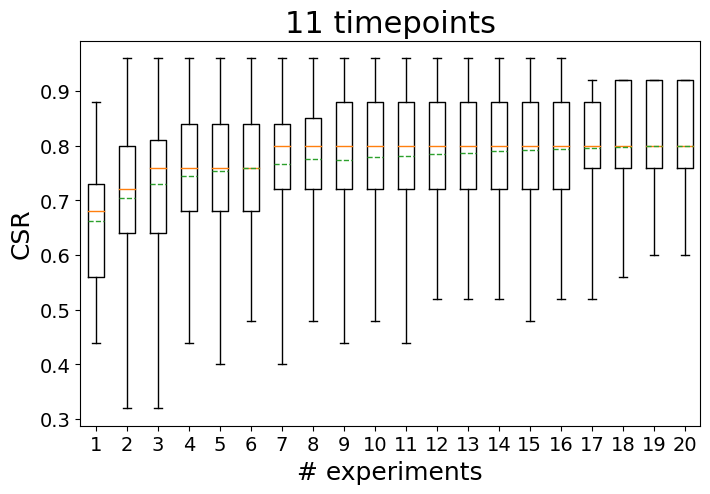

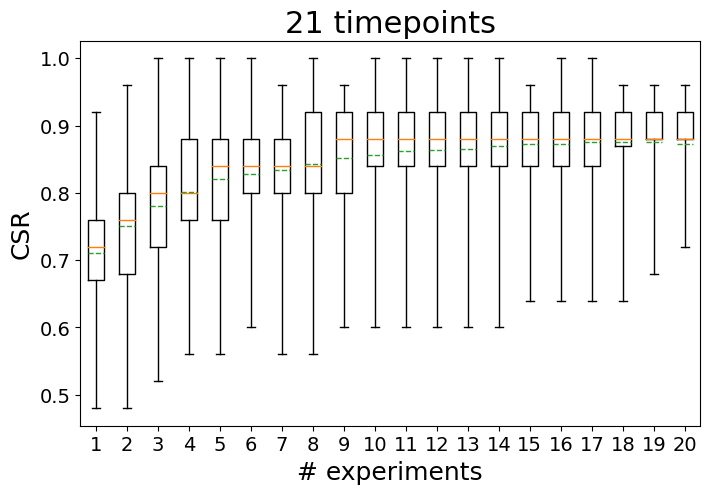

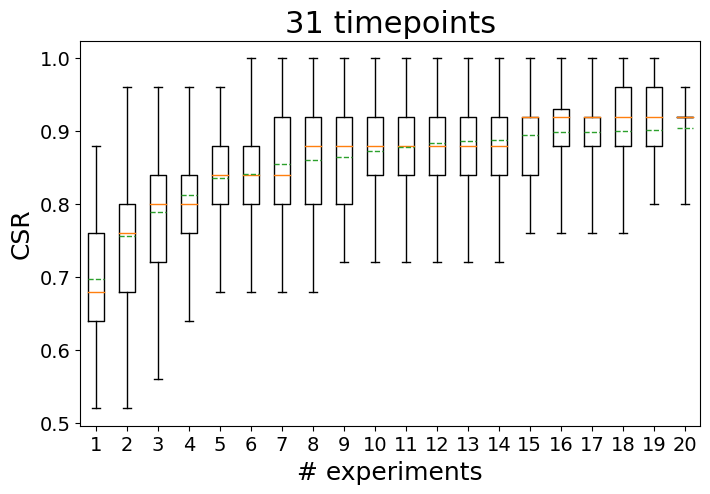

In [13]:
# CSR boxplot over # of experiments, by n_tpoints
for i in range(len(log.attrs["n_samples"])):
    df = pd.concat([pd.read_csv(i, index_col=0)
                   for i in inferfiles[i]], axis=0).reset_index(drop=True)

    CSR = [df[df["n_init_cond"] == i]
           ["CSR"].values for i in df.n_init_cond.unique()]

    plt.figure(figsize=(8, 5))
    plt.title(f"{log.attrs['n_samples'][i]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


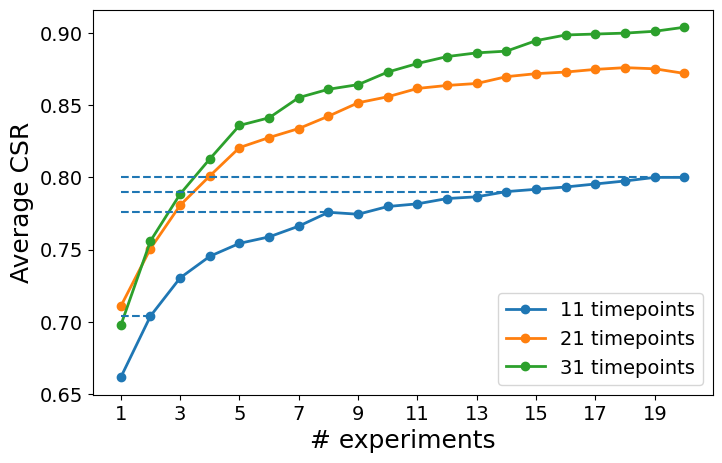

In [14]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0)
                   for k in inferfiles[i]], axis=0).reset_index(drop=True)

    for j in range(log.attrs["n_init_cond"]):
        n_init_cond = df["n_init_cond"].unique()[j]
        avgCSR[i, j] = df[df["n_init_cond"] ==
                          n_init_cond]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()


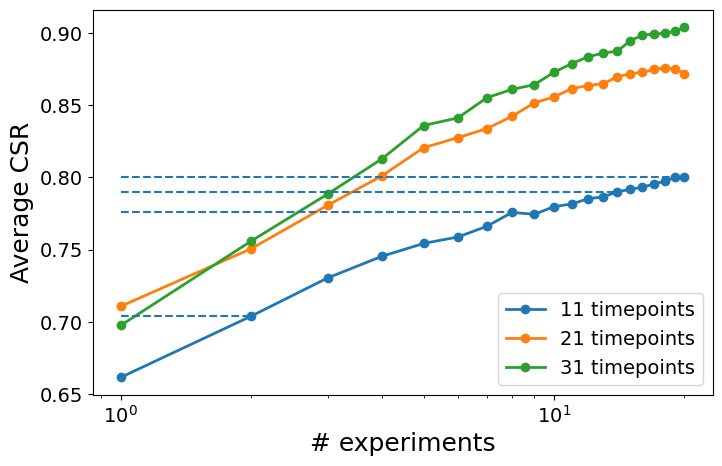

In [15]:
# average CSR over time
avgCSR = np.zeros((len(log.attrs["avg_samp_dt"]), log.attrs["n_init_cond"]))
for i in range(len(log.attrs["avg_samp_dt"])):
    df = pd.concat([pd.read_csv(k, index_col=0)
                   for k in inferfiles[i]], axis=0).reset_index(drop=True)

    for j in range(log.attrs["n_init_cond"]):
        n_init_cond = df["n_init_cond"].unique()[j]
        avgCSR[i, j] = df[df["n_init_cond"] ==
                          n_init_cond]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in log.attrs["n_samples"]]
plt.figure(figsize=(8, 5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1),
             avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0, i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
plt.show()


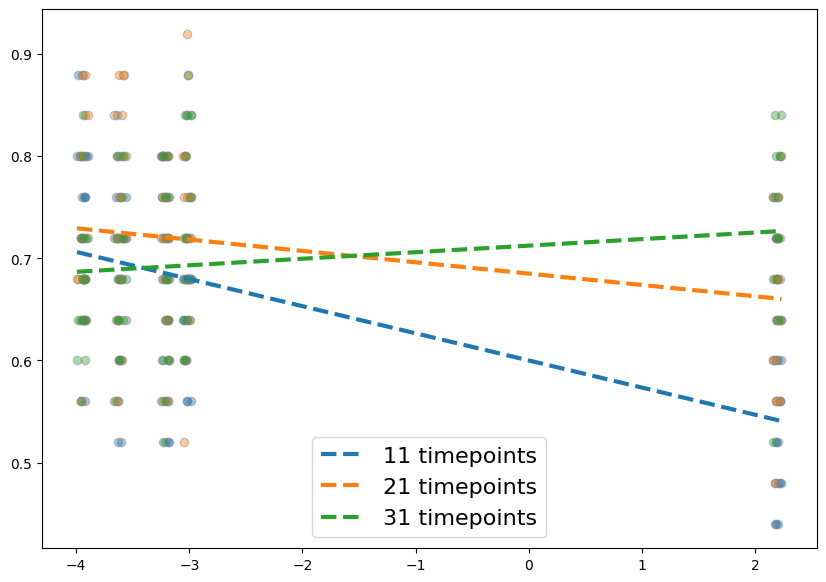

In [16]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    init_cond_msd = []
    csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        df_tmp = df[df["n_init_cond"] == 1]

        init_cond_idx = [int(re.findall("([0-9]+).0", i)[0])
                         for i in df_tmp.init_cond_idx]
        init_cond = metadict["init_cond"][init_cond_idx]

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond-x_eq)**2).mean(axis=1))
        csr.append(df_tmp.CSR.values)

        plt.scatter(np.log(((init_cond-x_eq)**2).mean(axis=1)), df_tmp.CSR,
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    init_cond_msd = np.concatenate(init_cond_msd)
    csr = np.concatenate(csr)

    reg = lm.LinearRegression()
    reg.fit(np.log(init_cond_msd).reshape((-1, 1)), csr)
    plt.plot([np.log(init_cond_msd).min(), np.log(init_cond_msd).max()],
             reg.predict([[np.log(init_cond_msd).min()],
                         [np.log(init_cond_msd).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()


In [17]:
def dot_mean(m):
    avg_cos = 0
    avg_norm_prod = 0
    n = 0
    for i in range(len(m)-1):
        for j in range(i+1, len(m)):
            n += 1
            avg_cos += (m[i].dot(m[j])/(np.linalg.norm(m[i])
                        * np.linalg.norm(m[j]))-avg_cos)/n
            # avg_dot += (m[i].dot(m[j])-avg_dot)/n
            # avg_cos += (np.linalg.norm(m[i]-m[j])-avg_dot)/n
            avg_norm_prod += (np.linalg.norm(m[i])
                              * np.linalg.norm(m[j])-avg_norm_prod)/n

    return avg_cos, avg_norm_prod


In [18]:
def distances(m):
    n = 0
    avg_dist = 0
    for i in range(m.shape[0]-1):
        for j in range(i+1, m.shape[0]):
            n += 1
            avg_dist += (np.linalg.norm(m[i]-m[j])-avg_dist)/n

    return avg_dist


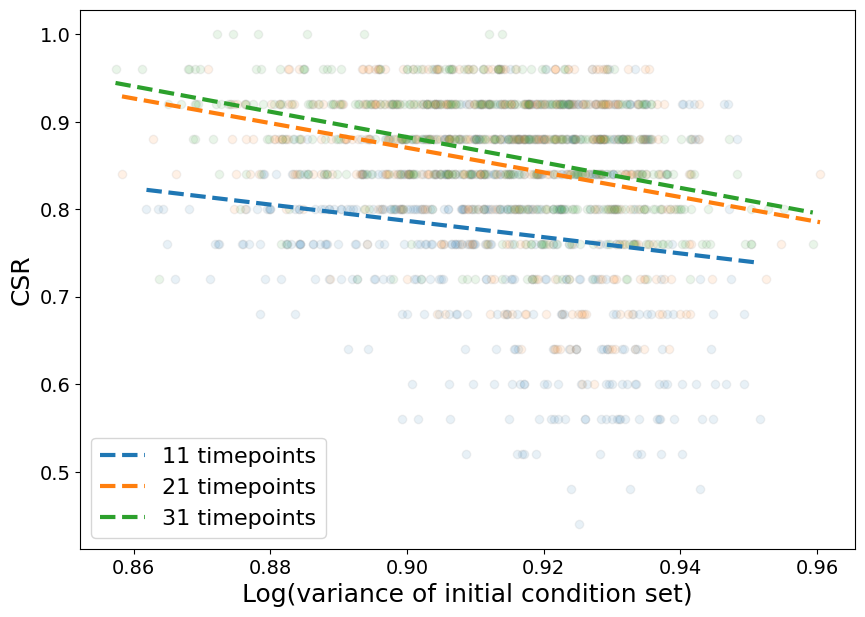

In [19]:
plt.figure(figsize=(10, 7))

# for j in range(2, 3):
for j in range(len(log.attrs["n_samples"])):
    total_init_cond_dot = []
    total_csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(9, 10):
            df_tmp = df[df["n_init_cond"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_x_eq_dot_mean = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                # init_cond_x_eq = init_cond#/np.sqrt((init_cond**2).sum(axis=0))#-x_eq/x_eq.sum()
                init_cond_x_eq = init_cond / \
                    init_cond.sum(axis=0)-x_eq/x_eq.sum()
                init_cond_x_eq /= np.linalg.norm(init_cond_x_eq,
                                                 axis=1).reshape((-1, 1))

                # init_cond_x_eq_dot_mean.append(distances(init_cond_x_eq))
                # init_cond_x_eq_dot_mean.append(np.linalg.norm(init_cond_x_eq, axis=1).mean())
                init_cond_x_eq_dot_mean.append(dot_mean(init_cond_x_eq)[0])
                csr.append(df_tmp.CSR.values[l])

            init_cond_x_eq_dot_mean = np.array(init_cond_x_eq_dot_mean)
            csr = np.array(csr)

            total_init_cond_dot.append(init_cond_x_eq_dot_mean)
            total_csr.append(csr)

    total_init_cond_dot = np.concatenate(total_init_cond_dot)
    total_csr = np.concatenate(total_csr)

    plt.scatter((total_init_cond_dot), total_csr,
                c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit((total_init_cond_dot).reshape((-1, 1)), total_csr)
    plt.plot([(total_init_cond_dot).min(), (total_init_cond_dot).max()],
             reg.predict([[(total_init_cond_dot).min()],
                         [(total_init_cond_dot).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
# plt.xscale("log")
plt.show()


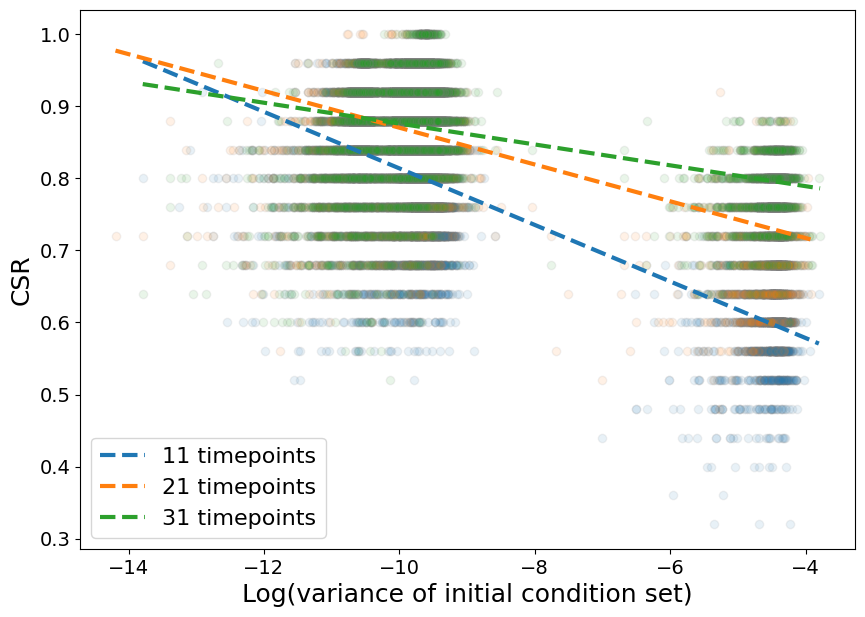

In [20]:
plt.figure(figsize=(10, 7))

for j in range(len(log.attrs["n_samples"])):
    total_init_cond_var = []
    total_csr = []

    for p in range(log.attrs["n_params_seeds"]):
        df = pd.read_csv(inferfiles[j][p], index_col=0)

        metadict = get_meta(open(metadatafiles[j][p], "r").read().split("\n"))

        p = metadict["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        for n in range(2, 21):
            df_tmp = df[df["n_init_cond"] == n]

            init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)]
                             for i in df_tmp.init_cond_idx.values]

            init_cond_var = []
            csr = []

            for l in range(len(init_cond_idx)):
                init_cond = metadict["init_cond"][init_cond_idx[l]]

                init_cond_var.append(init_cond-x_eq/10)
                csr.append(df_tmp.CSR.values[l])

            init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
            csr = np.array(csr)

            total_init_cond_var.append(init_cond_var)
            total_csr.append(csr)

    total_init_cond_var = np.concatenate(total_init_cond_var)
    total_csr = np.concatenate(total_csr)

    plt.scatter(np.log(total_init_cond_var), total_csr,
                c=f"C{j}", alpha=0.1, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(total_init_cond_var).reshape((-1, 1)), total_csr)
    plt.plot([np.log(total_init_cond_var).min(), np.log(total_init_cond_var).max()],
             reg.predict([[np.log(total_init_cond_var).min()],
                         [np.log(total_init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

plt.xlabel("Log(variance of initial condition set)", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


In [21]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1, j]/avgCSR[0, i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2, j]/avgCSR[0, i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2, j]/avgCSR[1, i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))


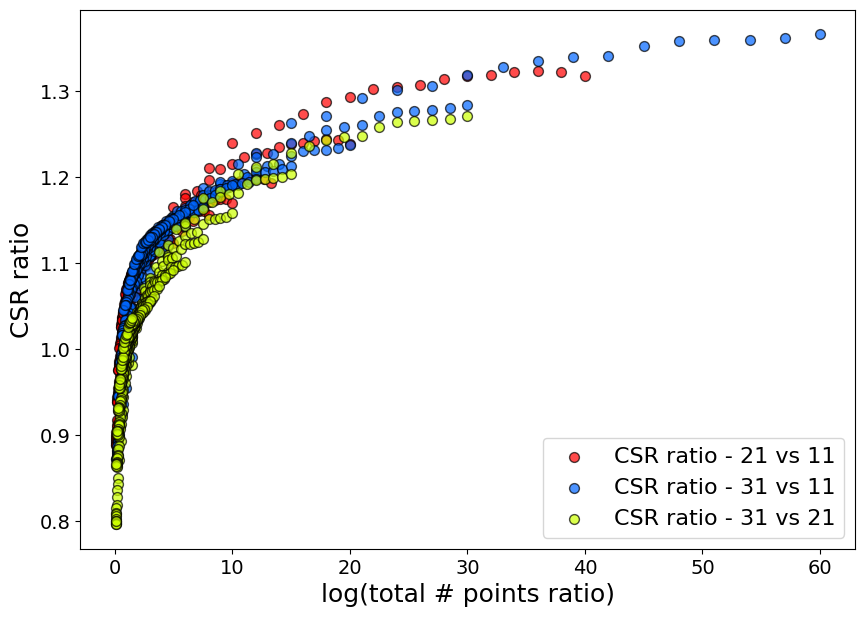

In [22]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

# 12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9607546343466054
intercept = 1.04572, slope = 0.06943

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9522166588041101
intercept = 1.03118, slope = 0.07730

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9675816948100313
intercept = 0.99236, slope = 0.07689

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.914995037810994
intercept = 1.02085, slope = 0.07780


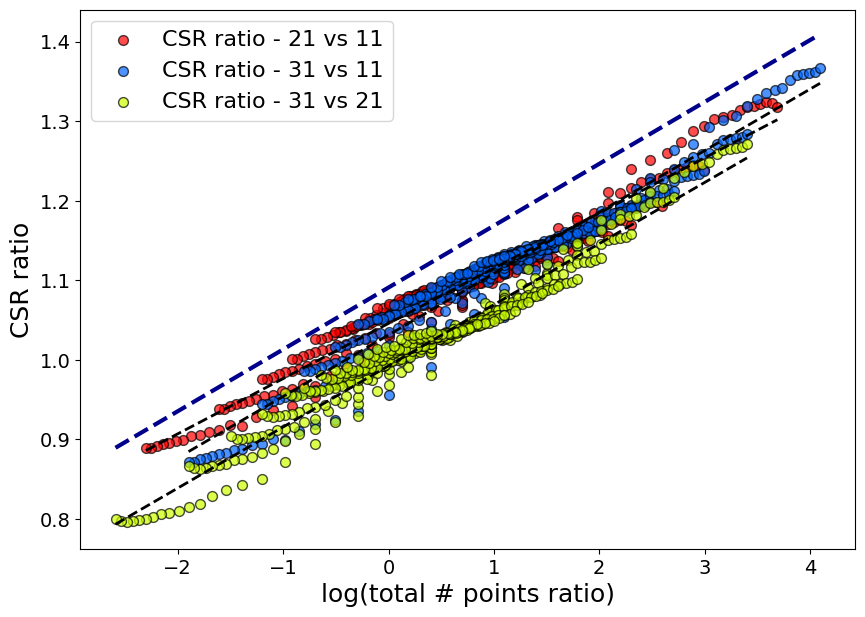

In [23]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0, 1, 1)), edgecolors="k",
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2, 1, 1)), edgecolors="k",
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9587926378756049
intercept = 0.04285, slope = 0.06377

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9401647760876697
intercept = 0.02954, slope = 0.07015

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.962376324360042
intercept = -0.01112, slope = 0.07566

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.905814234211774
intercept = 0.01766, slope = 0.07293


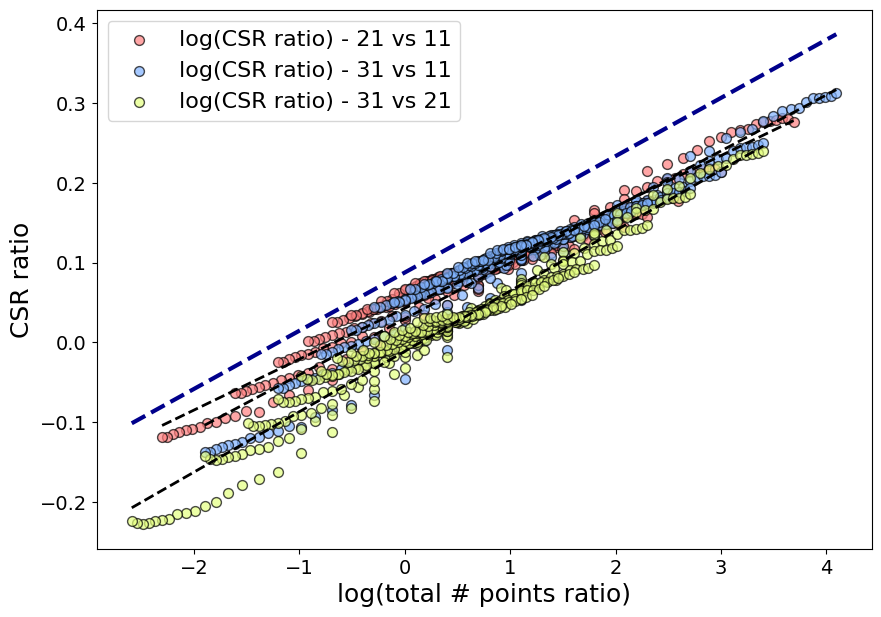

In [24]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

# 01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)),
                 np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio01).reshape((-1, 1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)),
                 np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio02).reshape((-1, 1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k",
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)),
                 np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio12).reshape((-1, 1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1))) +
         0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()


R2 score = 0.6084104135043105


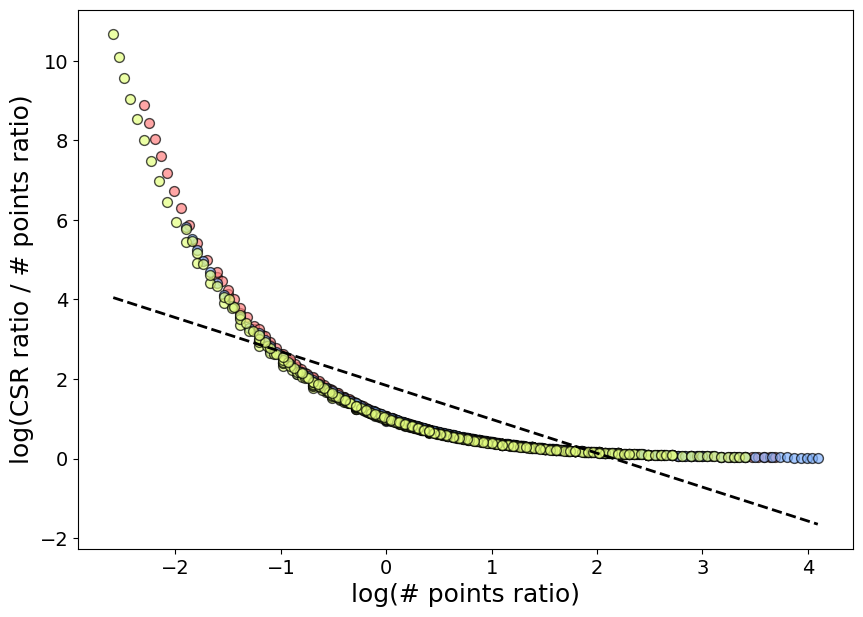

In [25]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01,
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02,
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12,
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(
    np.log(tpoints_ratio).reshape((-1, 1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


R2 score = 0.9993569882498354


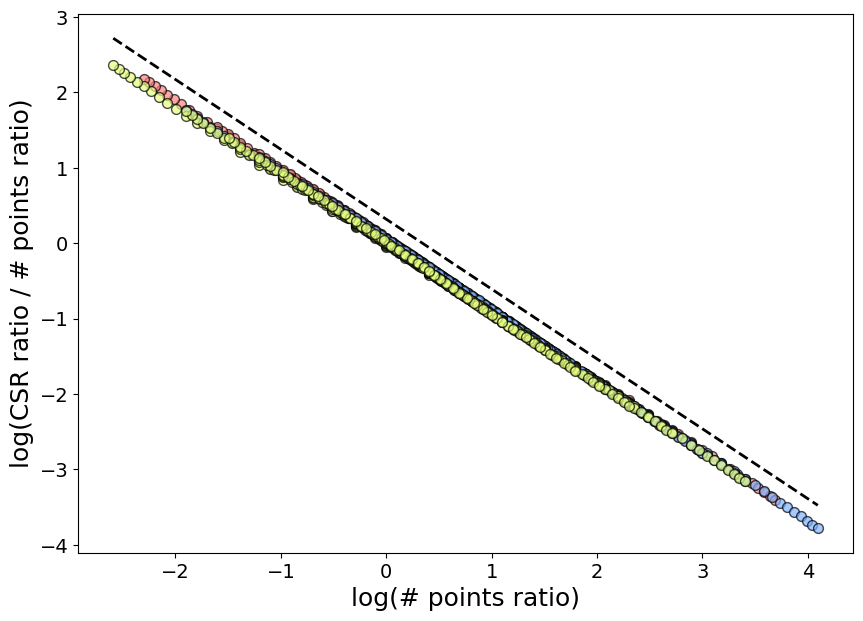

In [26]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10, 7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01),
            facecolors=hsv_to_rgb((0, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02),
            facecolors=hsv_to_rgb((0.6, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12),
            facecolors=hsv_to_rgb((0.2, 0.5, 1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate(
    (tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1, 1)),
        np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)),
                 np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1, 1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape(
    (-1, 1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


---

In [27]:
def lr_fim(x, y, lr, Sig):
    S = np.zeros((np.prod(x.shape), x.shape[1]*(x.shape[1]+1)))
    for i in range(x.shape[1]):
        S[i::x.shape[1], i] = 1.
        S[i::x.shape[1], (i+1)*x.shape[1]:(i+2)*x.shape[1]] = x

    F = S.T@np.diag(list(1/Sig)*x.shape[0])@S

    return F


In [28]:
def taros(x, y, lr):
    rms = np.zeros_like(lr.coef_)
    for i in range(rms.shape[0]):
        rms[i] = np.sqrt(((reg.coef_[i]*x/y[:,[i]])**2).sum(0))/len(x)

    return rms


In [29]:
def BIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*np.log(len(x)) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AIC(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def AICc(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return 2*n_p*(n_p+1)/(len(y)-n_p-1) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y)


def CAICF(x, y, lr, Sig):
    n_p = len(lr.intercept_)
    n_p *= n_p+1

    return n_p*(np.log(len(x))+2) + ((y-lr.predict(x))**2/Sig).sum() + len(y)*n_p*np.log(2*np.pi) + np.log(Sig.prod())*len(y) - np.log(np.linalg.det(lr_fim(x, y, lr, Sig)))

In [87]:
a = pd.read_csv(datafiles[0][2], index_col=0)
add_log_time_diff(a)

reg = lm.LinearRegression()
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

Sig = (dlogydt-reg.predict(y)).var(0)

F = lr_fim(y, dlogydt, reg, Sig)
cov = np.linalg.inv(F)

print(BIC(y, dlogydt, reg, Sig), AIC(y, dlogydt, reg, Sig),
      AICc(y, dlogydt, reg, Sig), CAICF(y, dlogydt, reg, Sig), np.log(np.linalg.det(taros(y, dlogydt, reg))))

6563.309514071288 6464.359993074847 6415.365910234611 6456.443520574898 9.457152800992432


In [88]:
true_params = get_meta(open(metadatafiles[0][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg.coef_)).mean(), np.sqrt(((true_A-reg.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg.coef_).flatten()**2/np.diag(cov)[n_sp:]).mean()), reg.score(y[:], dlogydt[:]), np.linalg.det(F))

ValueError: cannot reshape array of size 20 into shape (10,10)

In [89]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a["dataset"].unique():
y = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a[a["dataset"] < 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt_cv = a[a["dataset"] > 10].dropna(
)[[i for i in a.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

5.575021626362476 0.0
0.004110630351888483 0.0
0.7076419789754151 0.0
3079.8820253214994 0.0
3004.887735211592 0.0
2976.4131589404055 0.0
1.419068119611337e+62 0.0


In [91]:
a2 = pd.read_csv(datafiles[2][2], index_col=0)
add_log_time_diff(a2)

reg2 = lm.LinearRegression()
y2 = a2.dropna()[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt2 = a2.dropna()[[i for i in a2.columns if i[:6] == "dlogsp"]].values
reg2.fit(y2, dlogydt2)

Sig2 = (dlogydt2-reg2.predict(y2)).var(0)

F2 = lr_fim(y2, dlogydt2, reg2, Sig2)
cov2 = np.linalg.inv(F2)

print(BIC(y2, dlogydt2, reg2, Sig2), AIC(y2, dlogydt2, reg2, Sig2),
      AICc(y2, dlogydt2, reg2, Sig2), CAICF(y2, dlogydt2, reg2, Sig2), np.log(np.linalg.det(taros(y2, dlogydt2, reg2))))

25128.82038482219 24996.912495165707 24940.18138796008 25045.08427905245 4.764159184125291


In [94]:
n_sp = 5

In [95]:
true_params = get_meta(open(metadatafiles[2][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

print((np.sign(true_A) == np.sign(reg2.coef_)).mean(), np.sqrt(((true_A-reg2.coef_).flatten()**2).mean()),
      np.sqrt(((true_A-reg2.coef_).flatten()**2/np.diag(cov2)[n_sp:]).mean()), reg2.score(y2[:], dlogydt2[:]), np.linalg.det(F2))

0.92 0.31332996601376756 1.69672867722654 0.41686814320777843 2.6533686041157506e+62


In [96]:
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AIC(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

41632.46102661194
28752.405516027546


In [97]:
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg, Sig))
print(AICc(np.concatenate((y, y2)), np.concatenate((dlogydt, dlogydt2)), reg2, Sig2))

41575.24129567023
28695.185785085836


In [37]:
print(AICc(y, dlogydt, reg, Sig))
print(AICc(y, dlogydt, reg2, Sig2))

3212.9293199963295
3491.925549338515


In [38]:
print(AICc(y2, dlogydt2, reg, Sig))
print(AICc(y2, dlogydt2, reg2, Sig2))

17777.819130253127
15130.99508853776


In [39]:
cv_taros = []
cv_var = []
cv_score = []
cv_BIC = []
cv_AIC = []
cv_AICc = []
cv_FIM = []

# for dataset in a2["dataset"].unique():
y = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt = a2[a2["dataset"] < 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

reg = lm.LinearRegression()
reg.fit(y, dlogydt)
Sig = (dlogydt-reg.predict(y)).var(0)

y_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:2] == "sp"]].values
dlogydt_cv = a2[a2["dataset"] > 10].dropna(
)[[i for i in a2.columns if i[:6] == "dlogsp"]].values

cv_taros.append(np.log((taros(y_cv, dlogydt_cv, reg)).sum()))
# cv_taros.append(np.log(np.linalg.det(taros(y_cv, dlogydt_cv, reg))))
cv_var.append(((dlogydt_cv-reg.predict(y_cv))**2).mean())
cv_score.append(reg.score(y_cv, dlogydt_cv))
cv_BIC.append(BIC(y_cv, dlogydt_cv, reg, Sig))
cv_AIC.append(AIC(y_cv, dlogydt_cv, reg, Sig))
cv_AICc.append(AICc(y_cv, dlogydt_cv, reg, Sig))
cv_FIM.append(np.linalg.det(lr_fim(y_cv, dlogydt_cv, reg, Sig)))

cv_taros = np.array(cv_taros)
cv_var = np.array(cv_var)
cv_score = np.array(cv_score)
cv_BIC = np.array(cv_BIC)
cv_AIC = np.array(cv_AIC)
cv_AICc = np.array(cv_AICc)
cv_FIM = np.array(cv_FIM)

print(cv_taros.mean(), cv_taros.std())
print(cv_var.mean(), cv_var.std())
print(cv_score.mean(), cv_score.std())
print(cv_BIC.mean(), cv_BIC.std())
print(cv_AIC.mean(), cv_AIC.std())
print(cv_AICc.mean(), cv_AICc.std())
print(cv_FIM.mean(), cv_FIM.std())

6.080935294616462 0.0
0.012190023943239427 0.0
0.5385149984937647 0.0
7022.894082154002 0.0
6927.105376627294 0.0
6879.5885981038045 0.0
2.3774786716236984e+56 0.0


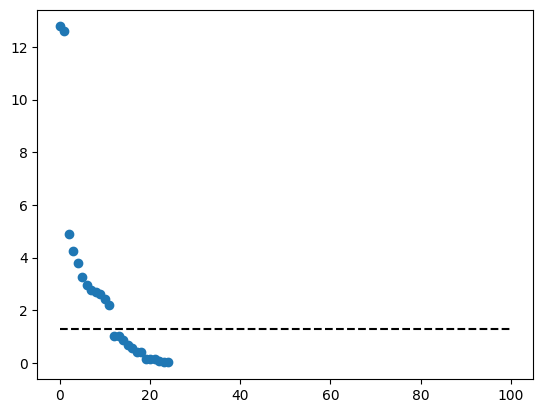

In [40]:
plt.plot(np.sort((taros(y, dlogydt, reg).flatten()))[::-1], "o")
plt.hlines(np.sort((taros(y, dlogydt, reg).flatten()))
           [::-1].max()/10, 0, 100, color="k", ls="--")


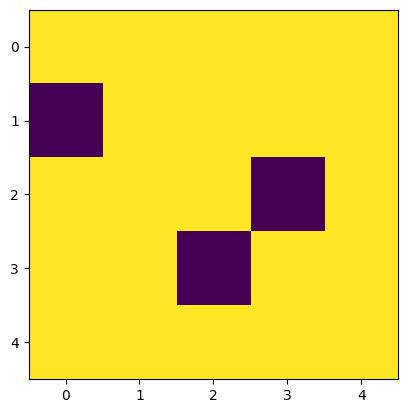

In [41]:
plt.imshow((np.sign(true_A) == np.sign(reg.coef_)))


0.7600074659625004 1.2169677549258069


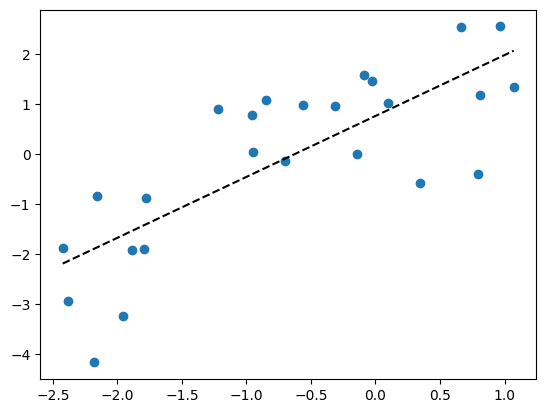

In [42]:
plt.scatter(np.log(np.abs(reg.coef_).flatten()),
            np.log(taros(y, dlogydt, reg).flatten()))
meta_reg = lm.LinearRegression()
meta_reg.fit(np.log(np.abs(reg.coef_).flatten()).reshape(
    (-1, 1)), np.log(taros(y, dlogydt, reg).flatten()))
plt.plot(np.sort(np.log(np.abs(reg.coef_).flatten()))[[0, -1]], meta_reg.predict(np.sort(
    np.log(np.abs(reg.coef_).flatten()))[[0, -1]].reshape((-1, 1))), color="k", ls="--")

print(meta_reg.intercept_, meta_reg.coef_[0])


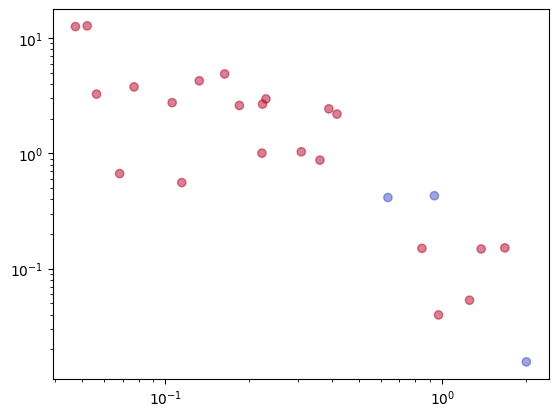

In [43]:
plt.scatter(np.diag(cov)[n_sp:]**0.5/np.abs(reg.coef_).flatten(), taros(y, dlogydt, reg).flatten(),
            c=(np.sign(reg.coef_) == np.sign(true_A)).flatten(), cmap="coolwarm", alpha=0.5)
plt.xscale("log")
plt.yscale("log")


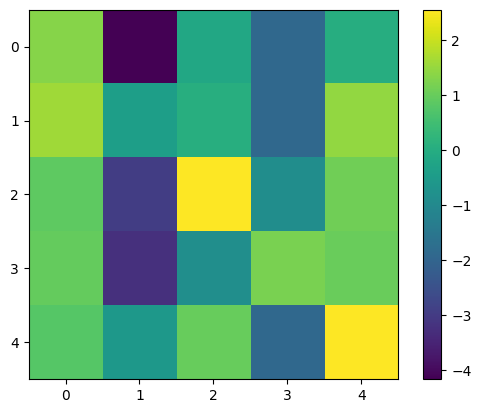

In [44]:
plt.imshow(np.log(taros(y, dlogydt, reg).T))
plt.colorbar()
plt.show()


In [45]:
from scipy.linalg import block_diag
import scipy.stats as st

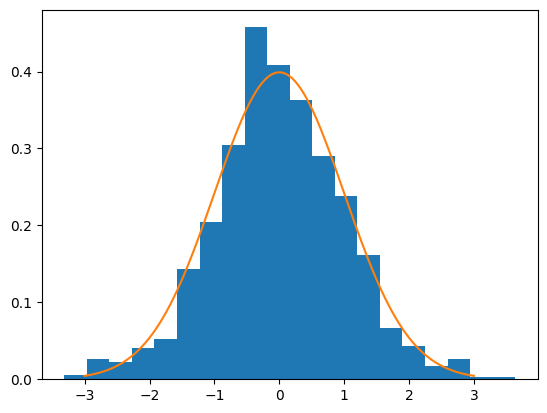

In [46]:
plt.hist(((dlogydt-reg.predict(y))/(dlogydt-reg.predict(y)).std()
          ).flatten(), 20, density=True)
l = np.linspace(-3, 3, 1000)
plt.plot(l, st.norm.pdf(l))


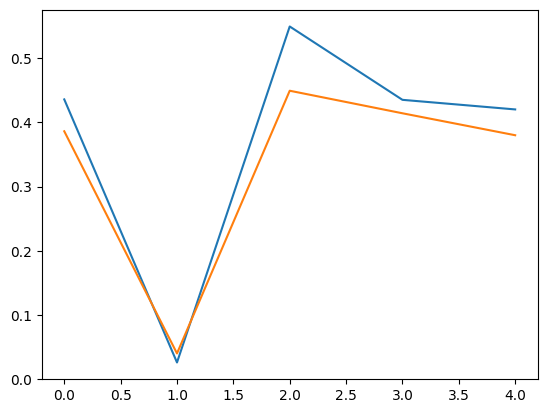

In [47]:
plt.plot(true_params[:n_sp])
plt.plot(reg.intercept_)


In [48]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.88

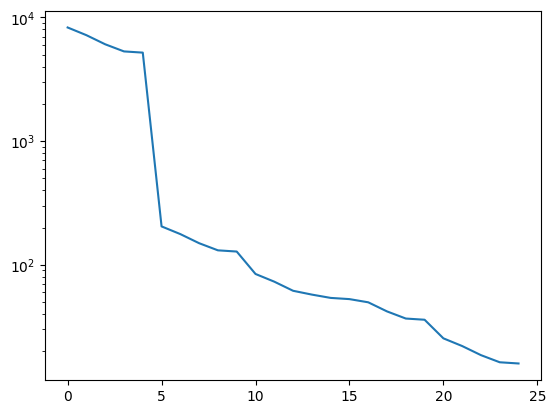

In [49]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


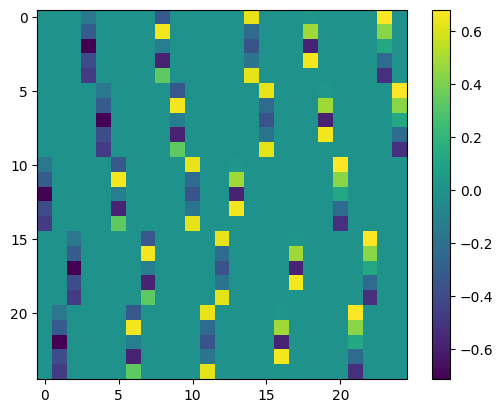

In [50]:
plt.imshow(np.linalg.eig(F[n_sp:, n_sp:])[1][:, np.argsort(
    np.linalg.eig(F[n_sp:, n_sp:])[0])][:, ::-1])
plt.colorbar()


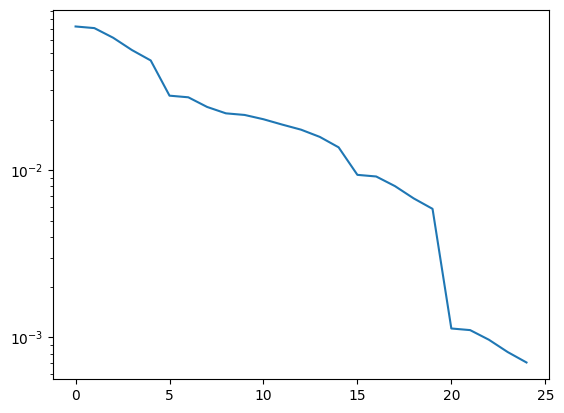

In [51]:
plt.plot(np.sort(np.linalg.eig(cov[n_sp:, n_sp:])[0])[::-1])
# plt.xscale("log")
plt.yscale("log")


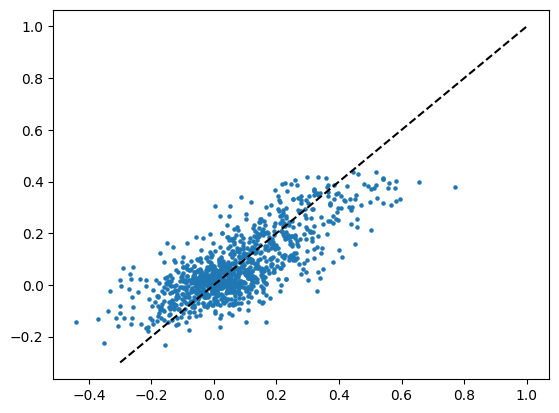

In [52]:
plt.scatter(dlogydt, reg.predict(y), s=5)
plt.plot([-0.3, 1], [-0.3, 1], ls="--", c="k")


In [53]:
(np.sign(true_A) == np.sign(reg.coef_)).mean()


0.88

(array([1.00408429, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.00816859]),
 array([-4.16431563, -3.83233819, -3.50036075, -3.16838331, -2.83640587,
        -2.50442843, -2.17245099, -1.84047355, -1.50849611, -1.17651867,
        -0.84454123]),
 [<matplotlib.patches.Polygon at 0x7f223353ed40>])

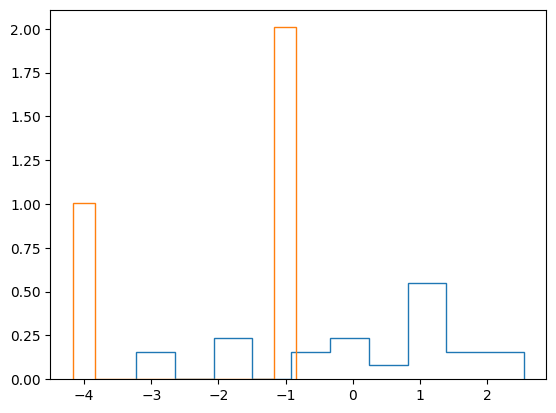

In [54]:
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) == np.sign(reg.coef_)).flatten()], histtype="step", density=True)
plt.hist(np.log(taros(y, dlogydt, reg)).flatten()[
         (np.sign(true_A) != np.sign(reg.coef_)).flatten()], histtype="step", density=True)
# plt.yscale("log")


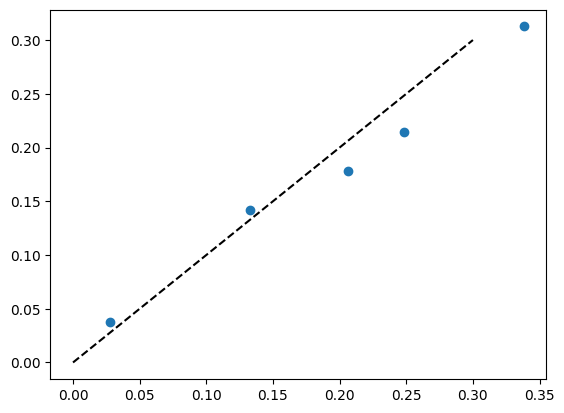

In [55]:
plt.scatter(-np.linalg.inv(true_A)@true_r, -
            np.linalg.inv(reg.coef_)@reg.intercept_)
plt.plot([0, 0.3], [0, 0.3], c="k", ls="--")


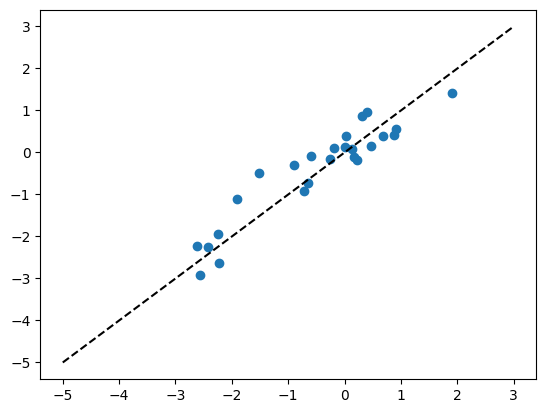

In [56]:
plt.scatter(true_A.flatten(), reg.coef_.flatten())
plt.plot([-5, 3], [-5, 3], c="k", ls="--")


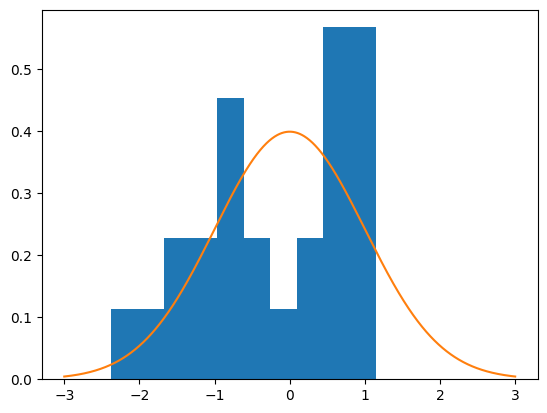

In [57]:
import scipy.stats as st
plt.hist((true_A-reg.coef_).flatten() /
         (true_A-reg.coef_).std(), 10, density=True)
x = np.linspace(-3, 3, 1000)
plt.plot(x, st.norm.pdf(x, scale=1))


In [58]:
(np.abs(true_A-reg.coef_).flatten()/np.diag(cov)[n_sp:]**0.5 < 0.5).mean()


0.04

<ErrorbarContainer object of 3 artists>

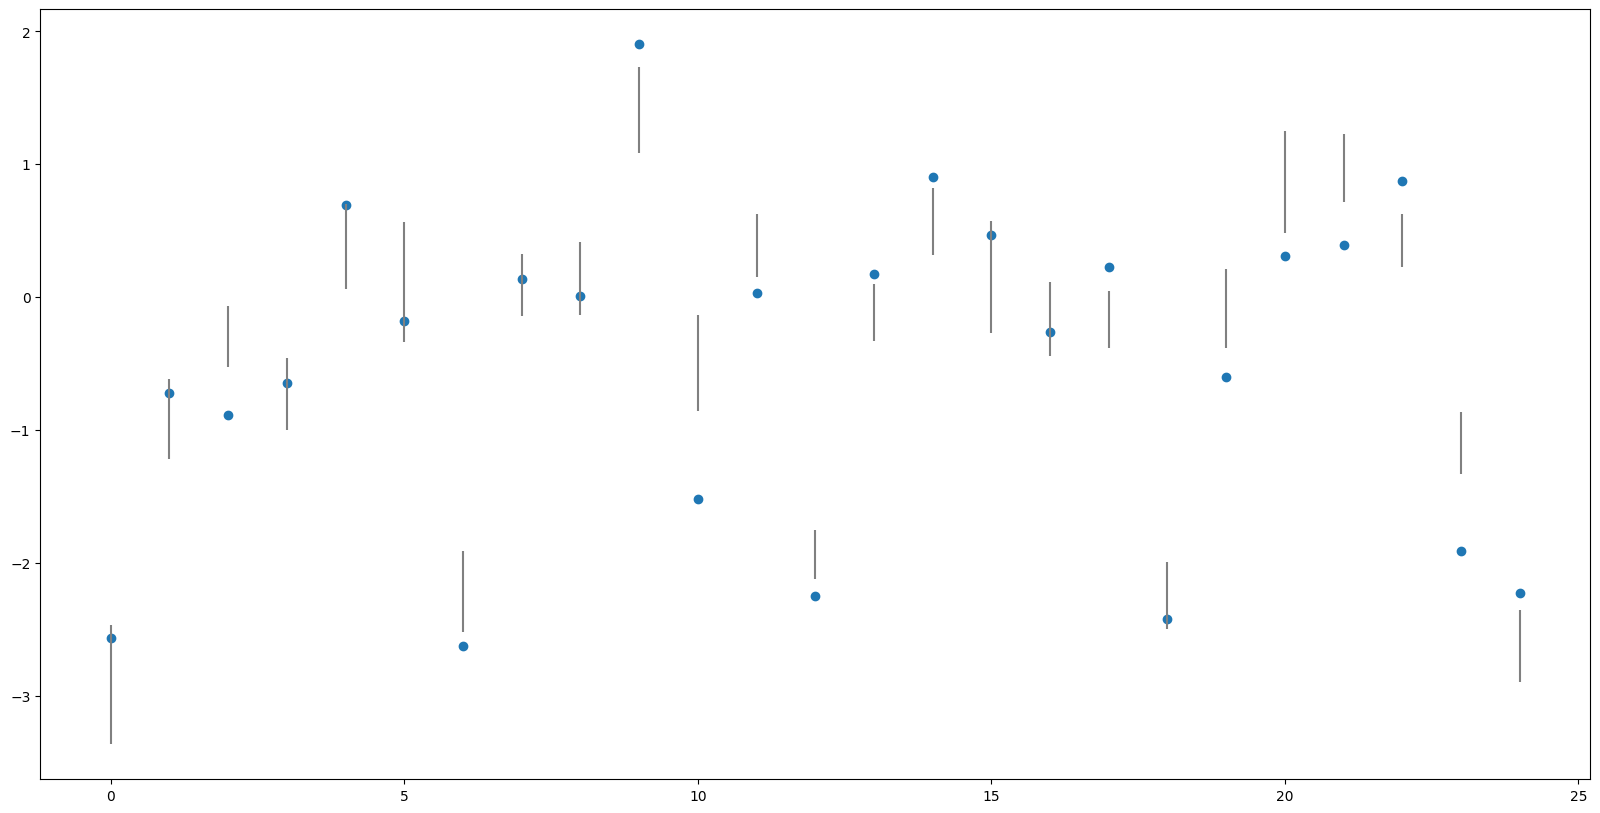

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(true_A.flatten(), "o")
# plt.plot(reg.coef_.flatten())
plt.errorbar(np.arange(n_sp**2), reg.coef_.flatten(), 2 *
             np.diag(cov)[n_sp:]**0.5, c="gray", fmt="none")
# plt.fill_between(np.arange(100), reg.coef_.flatten()-2*np.diag(cov)[n_sp:]**0.5, reg.coef_.flatten()+2*np.diag(cov)[n_sp:]**0.5, alpha=0.5, color="gray")


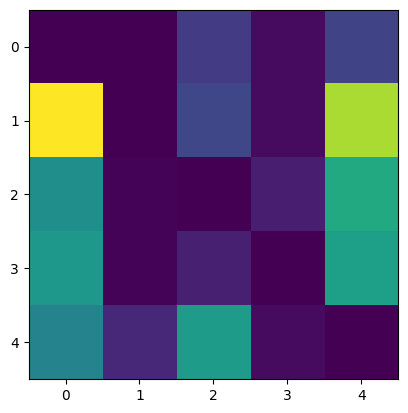

In [60]:
plt.imshow((taros(y, dlogydt, reg)-np.eye(n_sp)*taros(y, dlogydt, reg)).T)


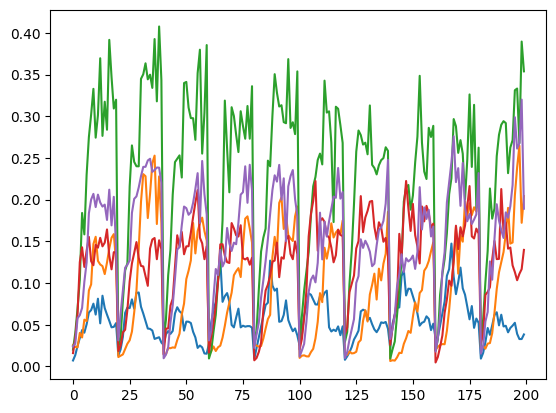

In [61]:
plt.plot(y)

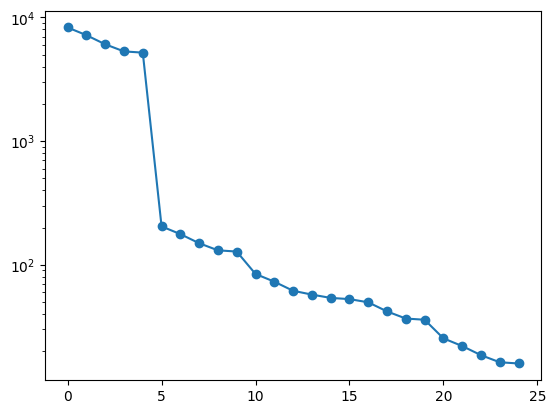

In [62]:
plt.plot(np.sort(np.linalg.eig(F[n_sp:, n_sp:])[0])[::-1], "-o")
plt.yscale("log")

In [63]:
corr = cov.copy()

for i in range(len(cov)):
    for j in range(len(cov)):
        corr[i, j] /= np.sqrt(cov[i, i]*cov[j, j])

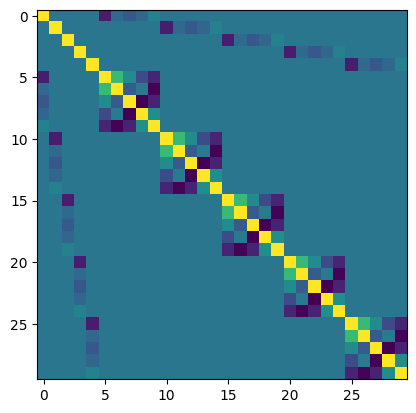

In [64]:
plt.imshow(corr)

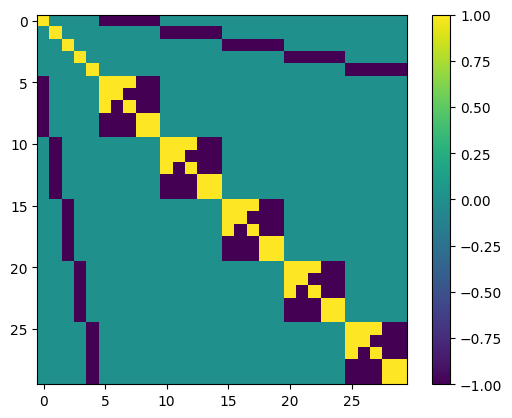

In [65]:
cov = np.linalg.inv(lr_fim(y, dlogydt, reg, Sig))
plt.imshow(np.sign(cov))
plt.colorbar()
plt.show()

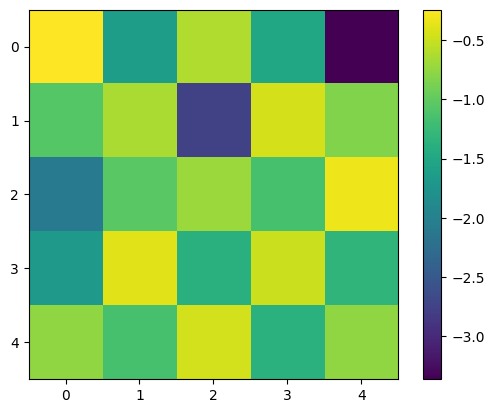

In [66]:
plt.imshow(np.log(np.abs(np.linalg.eig(cov[n_sp:2*n_sp, n_sp:2*n_sp])[1])))
plt.colorbar()
plt.show()

---

In [98]:
a = pd.read_csv(datafiles[0][2], index_col=0)

true_params = get_meta(open(metadatafiles[0][2]).read().split("\n"))[
    "parameters"]

true_r = true_params[:n_sp]
true_A = true_params[n_sp:].reshape((n_sp, n_sp))

add_log_time_diff(a)

reg = lm.LinearRegression()
y = a.dropna()[[i for i in a.columns if i[:2] == "sp"]].values
dlogydt = a.dropna()[[i for i in a.columns if i[:6] == "dlogsp"]].values
reg.fit(y, dlogydt)

LinearRegression()

In [99]:
dydt = a.dropna()[[i for i in a.columns if i[:3] == "dsp"]].values
dy = dydt*a.dropna()["dt"].values.reshape((-1,1))

In [100]:
@njit
def glv_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    return x * (r + A.dot(x))

@njit
def glv_and_grad_rhs(x, p):
    n = len(x)
    r = p[:n]
    A = p[n:].reshape((n,n))
    
    glv_rhs = x * (r + A.dot(x))

    glv_grad_rhs_x = x.reshape((-1,1))*A + np.diag(r + A@x)

    glv_grad_rhs_p = np.zeros((n, n*(n+1)))
    glv_grad_rhs_p[:n,:n] = np.diag(x)
    
    for i in range(n):
        glv_grad_rhs_p[i,n*(i+1):n*(i+2)] = x[i]*x

    return glv_rhs, glv_grad_rhs_x, glv_grad_rhs_p

In [2167]:
@njit
def euler(f, t, x_, p, n, dt):
    x = np.copy(x_)
    
    for i in range(n):
        x += dt * f(x, p)

    return x

@njit
def euler_f_and_grad(f_and_grad, t, x_, p, n, dt):
    x = np.copy(x_)
    x_grad_p = np.zeros((len(x), len(x)*(len(x)+1)))
    
    for i in range(n):
        f, f_grad_x, f_grad_p = f_and_grad(x, p)
        x += dt * f
        x_grad_p += dt * (f_grad_x@x_grad_p + f_grad_p)
        # x_grad_p += dt * f_grad_p

    return x, x_grad_p

In [2168]:
@njit
def pred(y, t, p, n):
    out = np.zeros_like(y)
    dt = np.diff(t)
    
    for i in range(len(out)):
        out[i] = euler(glv_rhs, t[i], y[i], p, n, dt[i]/n)

    return out

In [2169]:
@njit
def mse_grad(x, y, t, dt, p, n):
    s = np.zeros(x.shape[1]*(x.shape[1]+1))
    
    for i in range(x.shape[0]):
        pred, pred_grad = euler_f_and_grad(glv_and_grad_rhs, t[i], x[i], p, n, dt[i]/n)

        s += (y[i]-pred)@pred_grad

    return -2*s/(x.shape[0]*x.shape[1])

In [2170]:
mse_grad(x_hist[:-1], x_hist[1:], t_hist, np.diff(t_hist), p, 100)

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.])

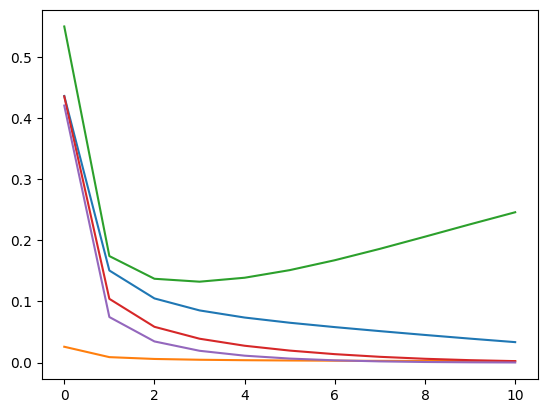

In [2165]:
n_sp = 5

np.random.seed(2)
x = np.random.uniform(0, 1, n_sp)
r = np.random.uniform(0, 1, n_sp)
A = np.random.normal(0, 1, (n_sp,n_sp))
A -= np.eye(n_sp)*A + np.abs(np.random.normal(0, 1, n_sp))*2

p = np.concatenate((r, A.flatten()))

t = 0.
t_hist = [t]
x_hist = [x]
dt = 0.01
n_steps = 10
n_dt = 100

for i in range(n_steps):
    x = euler(glv_rhs, t, x, p, n_dt, dt)
    t += n_dt*dt
    x_hist.append(x)
    t_hist.append(t)

x_hist = np.array(x_hist)
# x_hist += np.random.normal(0, 0.1, x_hist.shape)*x_hist
t_hist = np.array(t_hist)

plt.plot(t_hist, x_hist)
plt.show()

In [2130]:
reg = lm.LinearRegression()
reg.fit(x_hist[:-1], np.diff(np.log(x_hist)/(n_dt*dt), axis=0))
p_ = np.concatenate((reg.intercept_, reg.coef_.flatten()))
print((np.sign(reg.coef_)==np.sign(A)).mean())

0.52


In [2131]:
@njit
def batch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1):

    for i in range(n_it):
        g = mse_grad(x_hist[:-1], x_hist[1:], t_hist, np.diff(t_hist), p, n)
        Eg2 = gamma*Eg2 + (1-gamma)*g*g
        p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [2132]:
@njit
def minibatch_sgd_rmsprop(x_hist, t_hist, p, n, alpha, gamma, eps, Eg2, n_it=1, batch_size=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j in batch_idx:
            # print(j)
            g = mse_grad(x[j], y[j], t_hist[j], dt[j], p, n)
            Eg2 = gamma*Eg2 + (1-gamma)*g*g
            p -= alpha/(Eg2+eps)**0.5*g

    return p, Eg2

In [2133]:
@njit
def minibatch_sgd_adam(x_hist, t_hist, p, n, m, v, alpha=1e-3, b1=0.9, b2=0.999, eps=1e-8, n_it=1, batch_size=1, adam_t=1):
    x = x_hist[:-1]
    y = x_hist[1:]
    dt = np.diff(t_hist)
    idx = np.arange(len(x))

    for i in range(n_it):
        np.random.shuffle(idx)
        
        batch_idx = [idx[i*batch_size:(i+1)*batch_size] for i in range(len(x)//batch_size+1)]
        if len(batch_idx[-1]) < len(batch_idx[-2]):
            batch_idx[-2] = np.concatenate((batch_idx[-2], batch_idx[-1]))
        batch_idx = batch_idx[:-1]

        for j, batch in enumerate(batch_idx):
            g = mse_grad(x[batch], y[batch], t_hist[batch], dt[batch], p, n)
            m = b1*m+(1-b1)*g
            v = b2*v+(1-b2)*g**2
            m /= 1-b1**adam_t
            v /= 1-b2**adam_t
            p -= alpha*m/(np.sqrt(v)+eps)
            adam_t += 1

    return p, m, v, adam_t

In [2101]:
from pyDOE import lhs

In [2102]:
[i for i in range(10) if i!=3]

[0, 1, 2, 4, 5, 6, 7, 8, 9]

In [2105]:
p_res = lhs(30, 300, "center")*2-1
cr = 0.9
f = 0.5

for k in range(1000):
    for i, x in enumerate(p_res):
        a, b, c = p_res[np.random.choice([j for j in range(len(p_res)) if j!=i], 3, replace=False)]
        R = np.random.randint(0, 30)
        y = np.zeros(30)
        for j in range(30):
            r = np.random.rand()
            if r < cr or j==R:
                y[j] = a[j] + f*(b[j]-c[j])
            else:
                y[j] = x[j]

        Lx = mse(x_hist[1:], pred(x_hist[:-1], t_hist, x, 2))
        Ly = mse(x_hist[1:], pred(x_hist[:-1], t_hist, y, 2))

        if Ly <= Lx:
            p_res[i] = y

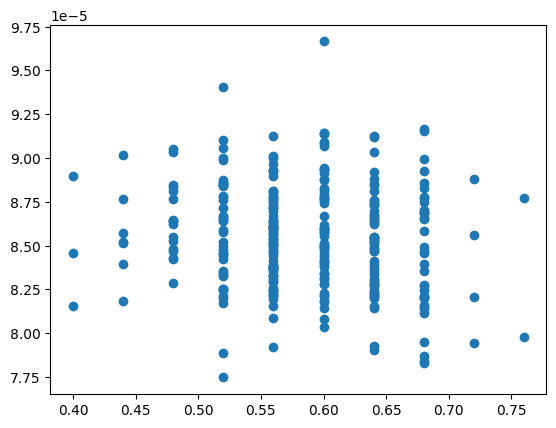

In [2106]:
plt.scatter([(np.sign(p_res[i,n_sp:])==np.sign(p[n_sp:])).mean() for i in range(len(p_res))], [mse(x_hist[1:], pred(x_hist[:-1], t_hist, i, 2)) for i in p_res])

Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x7f2256f50f70>
Traceback (most recent call last):
  File "/home/valeriano/.virtualenvs/base/lib64/python3.10/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):
KeyboardInterrupt: 


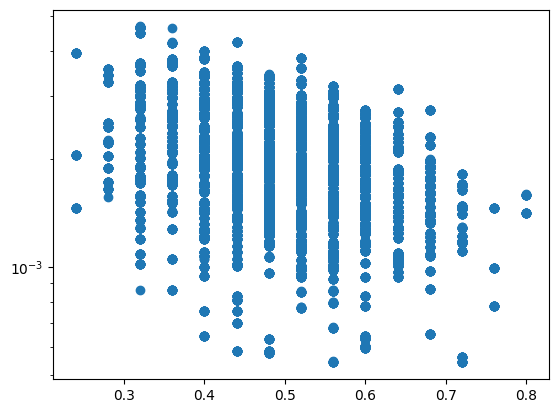

In [2134]:
# np.random.seed(2)
# p_res = np.random.normal(size=(10000, n_sp*(n_sp+1)))
p_res = lhs(30, 1000, "center")*2-1
# p_res = np.concatenate((reg.intercept_, -reg.coef_.flatten()))
# p_res = np.random.normal(0, 1, p.shape[0])*0
# p_res = p.copy()
# p_res = np.concatenate((np.ones(n_sp)/10, np.zeros(n_sp*n_sp)))

# alpha = 1e-1
gamma = 0.9
# eps = 1e-7
Eg2 = np.zeros_like(p_res)

n_dt_pred = 10

alpha = 1e-3
adam_t = 1
m = np.zeros_like(p_res)
v = np.zeros_like(p_res)
b1 = 0.9
b2 = 0.999
eps = 1e-8

csr = []
p_hist
mse_ = []

for p_res_i in p_res:
    adam_t = 1
    m = np.zeros_like(p_res_i)
    v = np.zeros_like(p_res_i)

    for i in range(10):
        p_res_i, m, v, adam_t = minibatch_sgd_adam(x_hist, t_hist, p_res_i, n_dt_pred, m, v, alpha=alpha, n_it=1, batch_size=10, adam_t=adam_t)
        # m /= 1-b1**adam_t
        # v /= 1-b2**adam_t
        # adam_t += 1
        csr.append((np.sign(p[n_sp:])==np.sign(p_res_i[n_sp:])).mean())
        mse_.append(mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res_i, n_dt_pred)))
        p_hist.append(p_res_i)

plt.plot(csr, mse_, "o")
plt.yscale("log")
plt.show()

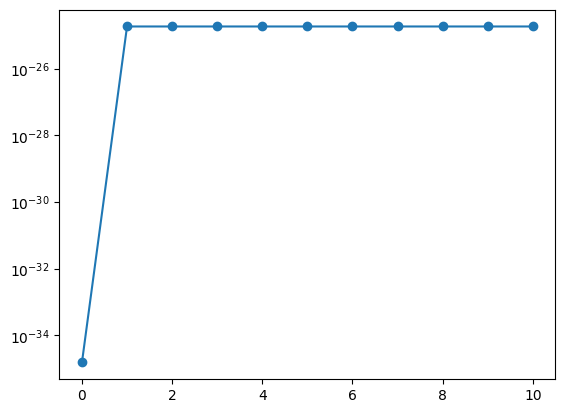

In [2135]:
# np.random.seed(2)
# p_res = np.random.normal(size=(n_sp*(n_sp+1)))
# p_res = np.concatenate((reg.intercept_, -reg.coef_.flatten()))
# p_res = np.random.normal(0, 1, p.shape[0])*0
p_res = p.copy()
# p_res = np.concatenate((np.ones(n_sp)/10, np.ones(n_sp*n_sp)))

# alpha = 1e-1
gamma = 0.9
# eps = 1e-7
Eg2 = np.zeros_like(p_res)

n_dt_pred = 10

alpha = 1e-3
adam_t = 1
m = np.zeros_like(p_res)
v = np.zeros_like(p_res)
b1 = 0.9
b2 = 0.999
eps = 1e-8

mse_hist = [mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred))]
p_hist = []

for i in range(10):
    # p_res, Eg2 = minibatch_sgd_rmsprop(x_hist, t_hist, p_res, n_dt_pred, alpha, gamma, eps, Eg2, 100, 1)
    # m *= 0.
    # v *= 0.
    p_res, m, v, adam_t = minibatch_sgd_adam(x_hist, t_hist, p_res, n_dt_pred, m, v, alpha=alpha, n_it=100, batch_size=10, adam_t=adam_t)
    # m /= 1-b1**adam_t
    # v /= 1-b2**adam_t
    # adam_t += 1
    mse_hist.append(mse(x_hist[1:], pred(x_hist[:-1], t_hist, p_res, n_dt_pred)))
    p_hist.append(p_res.copy())

plt.plot(mse_hist, "-o")
plt.yscale("log")
plt.show()

In [2136]:
print((np.sign(p[n_sp:])==np.sign(reg.coef_.flatten())).mean())
print((np.sign(p[n_sp:])==np.sign(p_res[n_sp:])).mean())

0.52
1.0


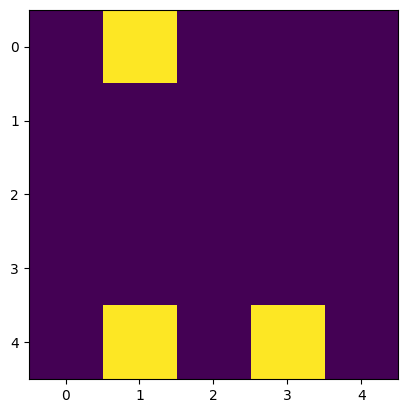

In [1962]:
plt.imshow(np.sign(p[n_sp:].reshape((n_sp,n_sp))))

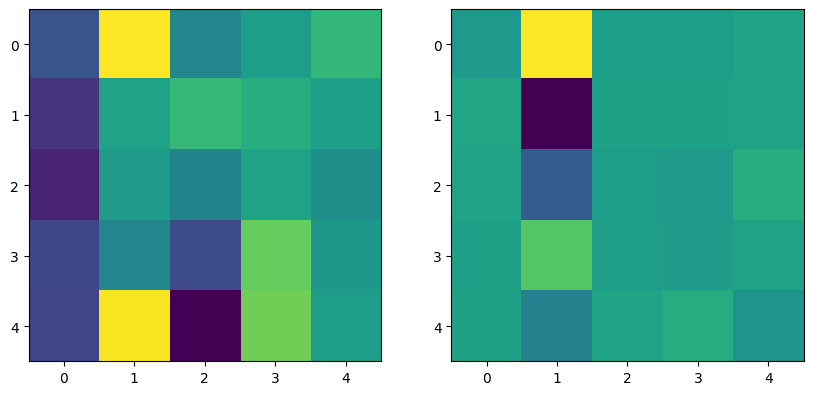

In [1968]:
plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(A)
plt.subplot(1, 2, 2)
plt.imshow(reg.coef_)
plt.show()

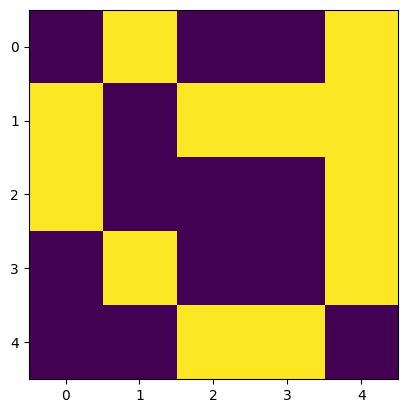

In [1963]:
plt.imshow(np.sign(reg.coef_))

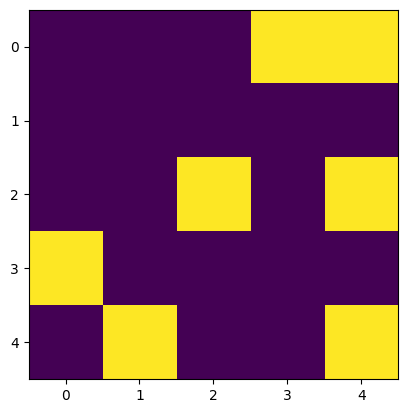

In [1964]:
plt.imshow(np.sign(p_res[n_sp:].reshape((n_sp,n_sp))))